In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec

import os
import pandas as pd
from typing import Tuple
from termcolor import colored
from pathlib import Path

from scipy.interpolate import interp1d
from scipy.integrate import trapz, quad

## ----- IMPORT DES FONCTIONS ----- ##

from dimensioning_functions.generate_Cx_Isp import generate_Cx_Isp
from dimensioning_functions.constraint_algo import constraints_algo
from dimensioning_functions.generate_csv_txt import generate_csv_txt
from dimensioning_functions.constraint_graphs import constraint_graphs

from design_functions.generate_missile_sections import generate_missile_section
from design_functions.generate_ogive_shape import generate_ogive_shape
from design_functions.generate_CG_missile import generate_CG_missile

from air_intakes_functions.External_diameter import Get_external_diameter
from air_intakes_functions.Internal_diameter import Get_internal_diameter
from air_intakes_functions.AirIntakes_thickness import Get_AI_thickness

from aero_function.Get_aero_components import Get_aero_components
from aero_function.Get_Steering_Angle import Get_Steering_Angle
from aero_function.Get_section_component import Get_section_component
from aero_function.Get_drag_data import Get_drag_data

## -------------------------------- ##


<div class="alert alert-info" align="center"><b>STOCKAGE DES INFORMATIONS</b></div>

In [23]:
docs_path = Path.cwd().parent / "Docs"
img_path = docs_path / "img"
resultats_path = docs_path / "resultats"

# Création des dossiers si nécessaire
for path in [docs_path, img_path, resultats_path]:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Le dossier {colored(path.name, 'green')} a été créé.")
    else:
        print(f"Le dossier {colored(path.name, 'yellow')} existe déjà.")

Le dossier Docs existe déjà.
Le dossier img existe déjà.
Le dossier resultats existe déjà.


<div class="alert alert-info" align="center"><b>SYNTHESE CONTRAINTE VARIABLES DU MISSILE - MOTEUR : STATORÉACTEUR</b></div>

In [24]:
## DONNÉES
t_acc = 4.85655564067031
t_cruise = 143.82010925319975
t_mission = t_acc + t_cruise

    # thermophysique
gamma = 1.4
P_amb = 101325
T_amb = 288
r_air = 8.314 / (28.966*1e-3)
g0 = 9.80665
Mach_cruise = 2.0
Mach_acc = 0.6
V_son = np.sqrt(gamma * r_air * T_amb)
Delta_Vr = (Mach_cruise - Mach_acc) * V_son

    # Impulsion spécifique
Isp_acc = 240

    # masse volumique
rho_a = 1800
rho_c = 1000
rho_payload = 3000
rho_equipement = 1500

    # masses
m_ogive = 25
m_equipement = 55
m_payload = 200
m_engine_h = 10
m_nozzle = 12
m_tails = 16

    # coefficient
c_a = 0.7
i_a = 0.28
c_c = 0.9
i_c = 0.22

    # diamètre vecteur
dt = 0.001
d_missile = np.arange(0.2, 0.6 + dt, dt)
shape = d_missile.shape[0]


<div class="alert alert-success" align="center"><b>PARAMÈTRES DE LA SIMULATION</b></div>

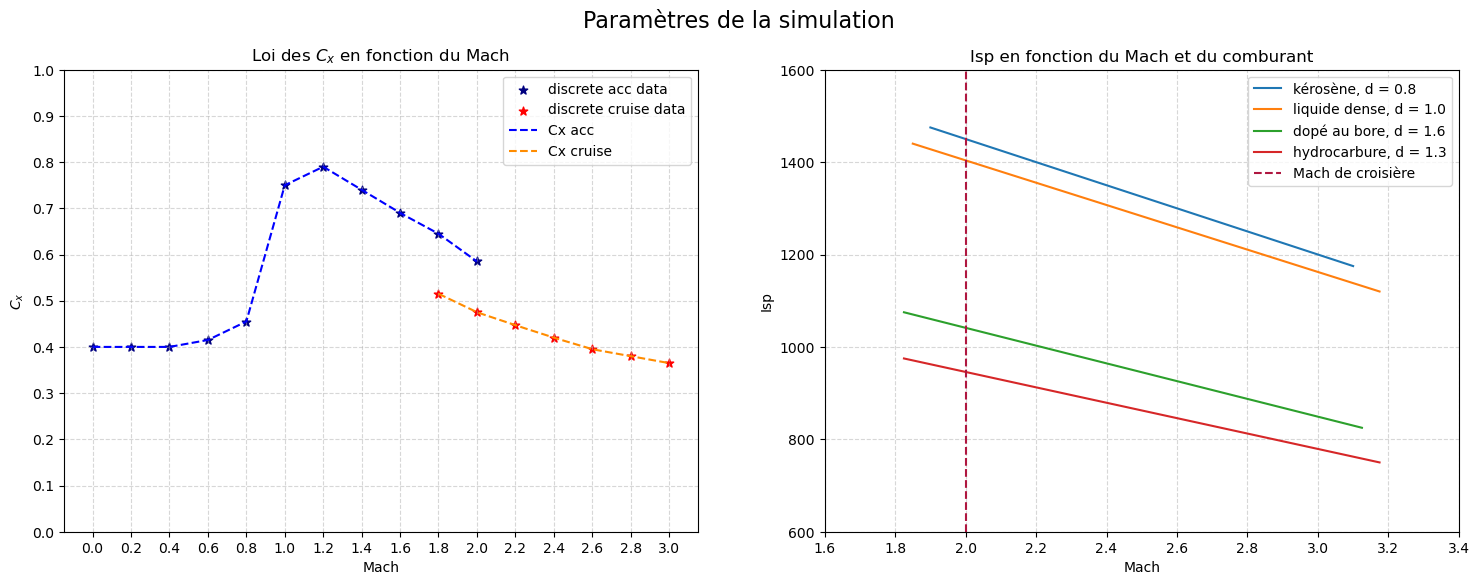

In [26]:
from dimensioning_functions.generate_Cx_Isp import generate_Cx_Isp

keys_dict_main, cruise_data_dict, Cx_acc_arr, Mach_acc_arr, isp_value, Cd_c, densite_value = generate_Cx_Isp(Mach_cruise=Mach_cruise, shape=d_missile.shape[0], 
                                                                                                             img_path=img_path)

time = {
    't_acc': t_acc,
    't_cruise': t_cruise,
}

data_mission = {
    'gamma': gamma,
    'P_amb': P_amb,
    'Mach_cruise': Mach_cruise,
    'g0': g0,
    'Cd_c': Cd_c,
    'Delta_Vr': Delta_Vr,
    'Isp_acc': Isp_acc,
    'mass': {
        'm_ogive': m_ogive,
        'm_equipement': m_equipement,
        'm_tails': m_tails,
        'm_payload': m_payload,
        'm_engine_h': m_engine_h,
        'm_nozzle': m_nozzle
    },
    'rho': {
        'rho_payload': rho_payload,
        'rho_equipement': rho_equipement,
        'rho_c': rho_c,
        'rho_a': rho_a
    },
}

c = {
    'c_a': c_a,
    'c_c': c_c
}

i = {
    'i_a': i_a,
    'i_c': i_c
}

graph_component = {
    'Mach_acc_arr': Mach_acc_arr,
    'Cx_acc_arr': Cx_acc_arr
}

iterate = {
    'keys_dict_main': keys_dict_main,
    'cruise_data_dict': cruise_data_dict
}

<div class="alert alert-info" align="center"><b>CONTRAINTES DU MISSILE</b></div>

In [5]:
mass_tensor, length_tensor, d_missile = constraints_algo(time=time, data_mission=data_mission, c=c, i=i, graph_component=graph_component, iterate=iterate)

In [6]:
generate_csv_txt(cruise_data_dict=cruise_data_dict, d_missile=d_missile, 
                 data_mission=data_mission, length_tensor=length_tensor, 
                 mass_tensor=mass_tensor, isp_value=isp_value, 
                 densite_value=densite_value, resultats_path=resultats_path, c=c)

In [7]:
## ----- OXYDANT ----- ## 
# "Kerosene", "Liquide dense", "Bore", "Hydrocarbure"

oxydizer = "Liquide dense"
idx_chosen_oxydizer = np.where(keys_dict_main == oxydizer)[0]

## ----- CHARGEMENT DU FICHIER ----- ##
results_path = os.path.join(resultats_path, f"{oxydizer}.csv")
results_df = pd.read_csv(results_path, sep="\t")

## ----- CARCATÉRISTIQUES DU MISSILE ----- ##
diametre = 0.35
idx_diametre = np.argmin(np.abs(results_df['d_m'] - diametre))
row = results_df.iloc[idx_diametre]

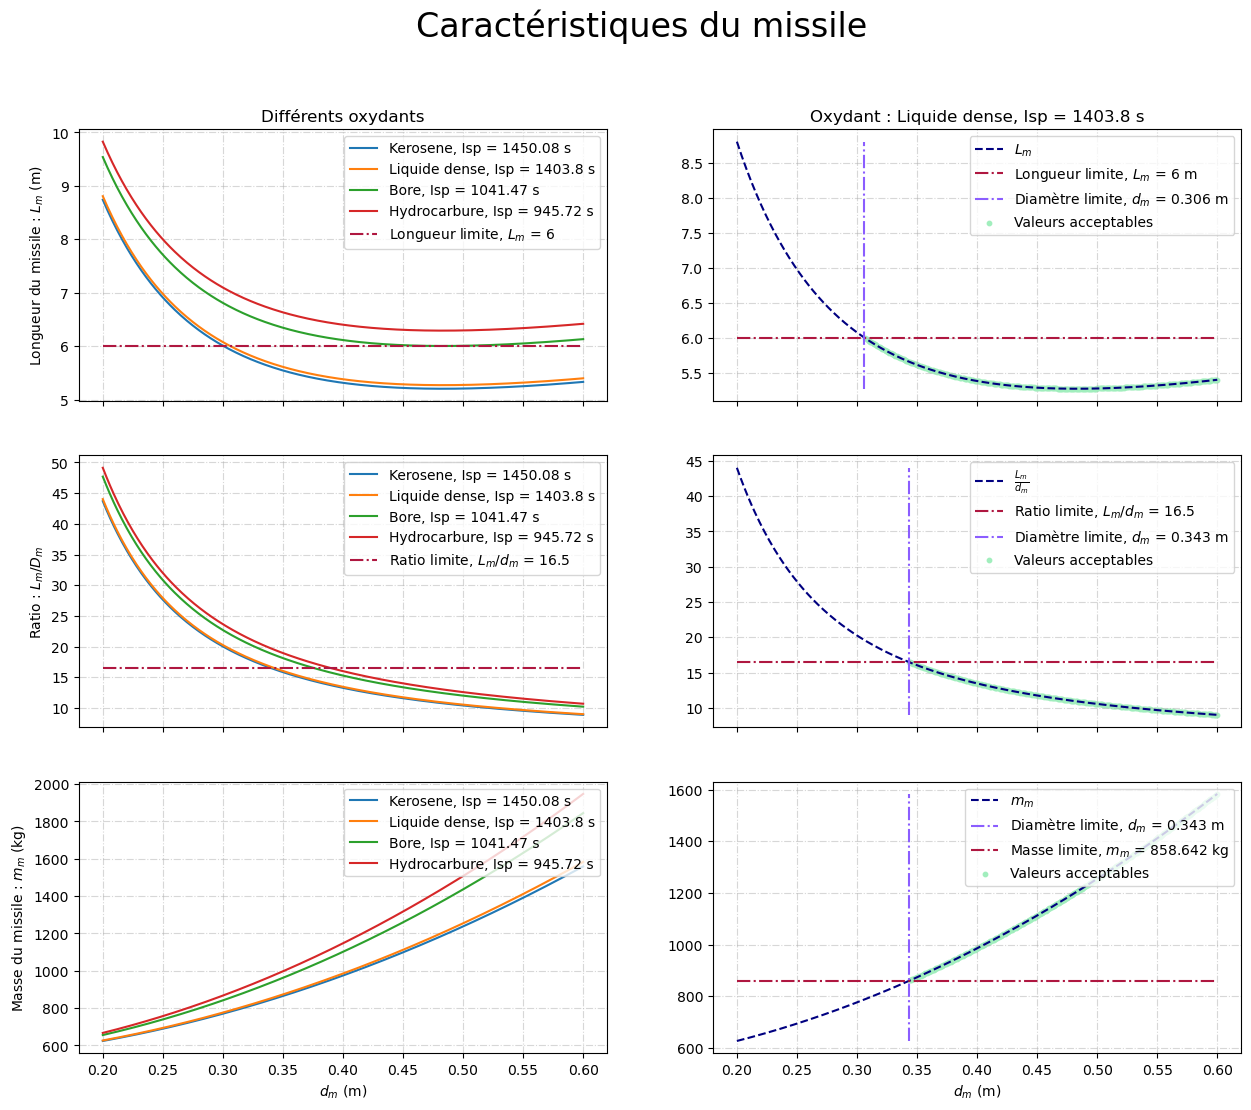

In [8]:
choosen_oxydiser = "Liquide dense"

constraint_graphs(choosen_oxydiser=choosen_oxydiser, keys_dict_main=keys_dict_main, 
                  length_tensor=length_tensor, mass_tensor=mass_tensor, 
                  d_missile=d_missile, isp_value=isp_value, 
                  cruise_data_dict=cruise_data_dict, img_path=img_path
                  )

<div class="alert alert-info" align="center"><b>DIMENSIONNEMENT DE L'OGIVE</b></div>

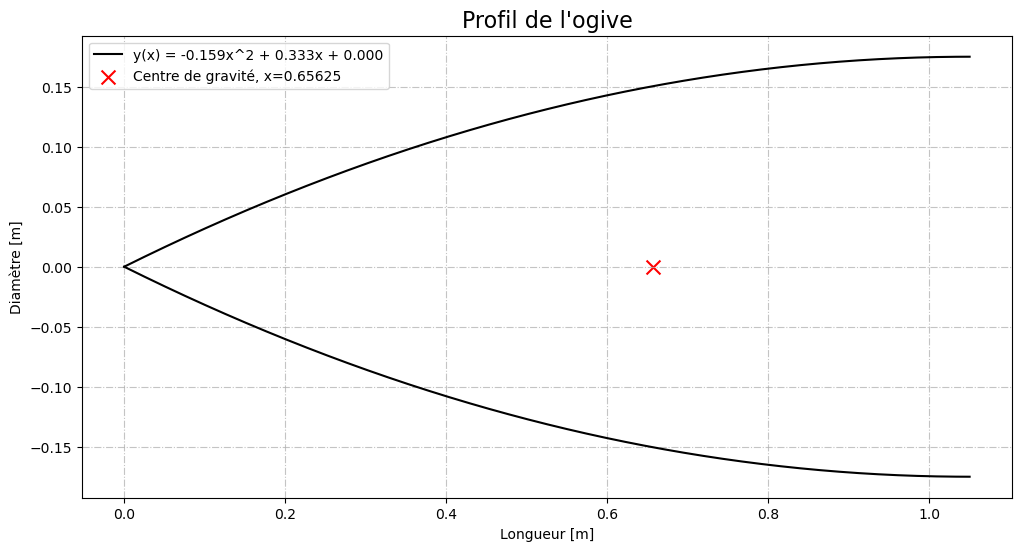

In [9]:
x_ogive, y_ogive, x_CG_ogive, coeff_ogive = generate_ogive_shape(row=row, diametre=diametre, img_path=img_path)

<div class="alert alert-info" align="center"><b>CALCUL DU CENTRE DE GRAVITÉ</b></div>

In [10]:
L_missile = row[1]
print(f"Longueur du missile : {colored(L_missile, 'blue')} m.")

Longueur du missile : 5.6116 m.


In [11]:
row

d_m                        0.35000
L_m                        5.61160
m_m                      873.14334
m_ogive                   25.00000
m_payload                200.00000
m_equipement              55.00000
m_cruise_res              42.01271
m_cruise_prop            148.95414
m_engine_housing          10.00000
m_acc_res                 66.81892
m_acc_prop               171.82007
m_nozzle                  12.00000
m_Tails                   16.00000
m_AirIntakes              65.62500
m_Wings                   59.91250
L_ogive                    1.05000
L_payload                  0.69292
L_equipement               0.38111
L_cruise_res               1.72022
L_cruise_prop              1.54820
L_engine_housing           0.17500
L_acc_res                  1.41735
L_acc_prop                 0.99215
L_nozzle                   0.17500
L_AirIntakes               3.31257
L_Tails                    0.35000
L_Wings                    1.05000
Impulsion spécifique    1403.80000
Masse volumique     

In [12]:
section_missile = generate_missile_section(row=row, x_ogive=x_ogive, y_ogive=y_ogive, x_CG_ogive=x_CG_ogive)

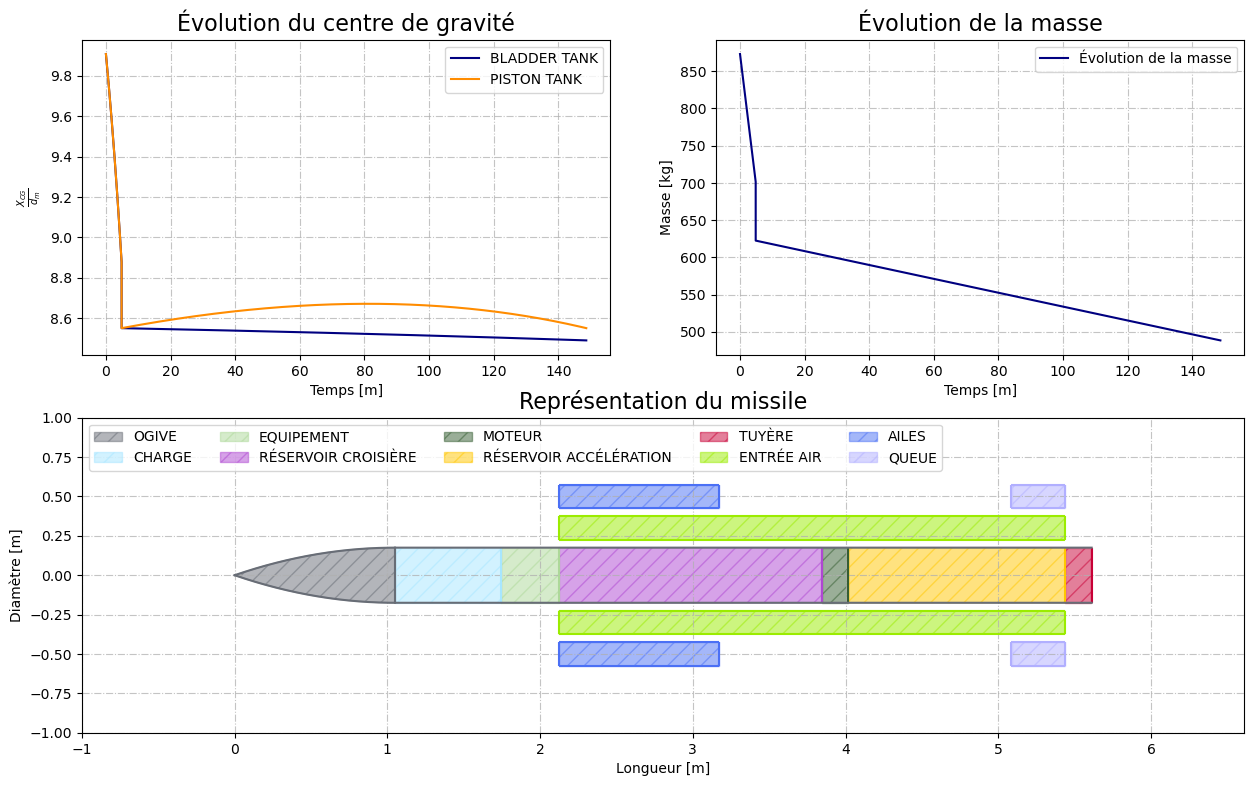

----- MASSE DE PROPERGOL POUR LA PHASE DE CROISIÈRE -----
Masse de propergol en fin de croisière : 14.895414000000017 kg
Il reste 14.89541 kg de propergol soit 10.0000 % de la masse totale.
Condition validé !


{'MASS': array([[ 25.    ,  25.    ,  25.    , ...,  25.    ,  25.    ,  25.    ],
        [200.    , 200.    , 200.    , ..., 200.    , 200.    , 200.    ],
        [ 55.    ,  55.    ,  55.    , ...,  55.    ,  55.    ,  55.    ],
        ...,
        [ 65.625 ,  65.625 ,  65.625 , ...,  65.625 ,  65.625 ,  65.625 ],
        [ 59.9125,  59.9125,  59.9125, ...,  59.9125,  59.9125,  59.9125],
        [ 16.    ,  16.    ,  16.    , ...,  16.    ,  16.    ,  16.    ]]),
 'MASS_TOT': array([873.14334   , 872.97134794, 872.79935588, ..., 488.71400984,
        488.57981692, 488.445624  ])}

In [13]:
mc_dot = row['m_cruise_prop'] / t_cruise
ma_dot = row["m_acc_prop"] / t_acc

m_dot = {
    'ma_dot': ma_dot,
    'mc_dot': mc_dot
}

CGx_dict, mass_dict, t_tot_array = generate_CG_missile(time=time, m_dot=m_dot, 
                                                       section_missile=section_missile, 
                                                       row=row, diametre=diametre, img_path=img_path)

mass_dict

In [14]:
# from design_functions.generate_GIF import GenerateGIF

# GenerateGIF(CGx_dict=CGx_dict, mass_dict=mass_dict, t_tot_array=t_tot_array, 
#             diametre=diametre, row=row, section_missile=section_missile, 
#             img_path=img_path)

<div class="alert alert-info" align="center"><b>DIMENSIONNEMENT DES ENTRÉES D'AIRS</b></div>

In [15]:
thermophysic = {
    'P_inf': 101325,
    'T_inf': 288.15,
    'gamma': 1.4,
    'r': 0.4,
}

oxydizer_density = 1.0

abacusvalue = {
    'omega': 0.1278,
    'theta': 0.5556,
    'sigma': 1.688
}

airintake_params = {
    'eps': 0.925,
    'eta': 0.85,
}

sigma_rupture = 700 * 1e6

external_diameter, Upstream_Stag = Get_external_diameter(thermophysic=thermophysic, oxydizer_density=oxydizer_density,
                                                         abacusvalue=abacusvalue, airintake_params=airintake_params,
                                                         cruise_mass_flow=mc_dot)

print(f"Diamètre externe - entrée d'air : {colored(external_diameter, 'blue')} m.\n")

internal_diameter, internal_mach = Get_internal_diameter(external_diameter=external_diameter, airintake_params=airintake_params, 
                                          abacusvalue=abacusvalue)

print(f"Diamètre interne - entrée d'air : {colored(internal_diameter, 'blue')} m.")
print(f"Nombre de mach interne : {colored(internal_mach, 'blue')}.")

thickness, real_thickness = Get_AI_thickness(thermophysic=thermophysic, airintake_params=airintake_params,
                                             Upstream_Stag=Upstream_Stag, mach=internal_mach,
                                             rupture_constraint=sigma_rupture, d_missile=diametre)

print(f"\nÉpaisseur de la couche d'acier : {colored(thickness, 'blue')} m.")
print(f"Épaisseur réelle de la couche d'acier : {colored(real_thickness, 'blue')} m.")

boundary_layer_trap = diametre / 15
h_AirIntakes = internal_diameter + 2 * thickness + boundary_layer_trap
print(f"\nDimensions des entrées d'air : \n     - Longueur : {colored(row['L_AirIntakes'], 'blue')} m\n     - Hauteur : {colored(h_AirIntakes, 'blue')} m")

## ----- DONNÉES ----- ##
# provenant ABAQUES REPORT 1135 page 49
mach_secure = 2.2
theta = np.deg2rad(25)
sigma = np.deg2rad(40)

def Get_x_value(diameter, sigma):

    return diameter / (2 * np.tan(sigma))

delta_X = Get_x_value(diameter=external_diameter, sigma=sigma)
print(f"\nTaille de la souris en sortie en entrée d'entrée d'air : {colored(delta_X, 'magenta')} m.")

Diamètre externe - entrée d'air : 0.12401024495017961 m.

L hypothèse est vérifiée, nous avons donc :
    - diamètre externe : d_1 = 0.12401024495017961 m.
    - diamètre interne : d_2 = 0.14881229394021553 m.

Diamètre interne - entrée d'air : 0.14881229394021553 m.
Nombre de mach interne : 0.2950617834394905.

Épaisseur de la couche d'acier : 0.001 m.
Épaisseur réelle de la couche d'acier : 0.00013326950962723656 m.

Dimensions des entrées d'air : 
     - Longueur : 3.31257 m
     - Hauteur : 0.17414562727354888 m

Taille de la souris en sortie en entrée d'entrée d'air : 0.07389482746893228 m.


In [16]:
dX = 100.998 *1e-3

Cn_dict = {
    'Cn_F': 2.95,
    'Cn_EA': 5.95
}

xd_position = {
    'xd_F': 2.5,
}

cst_values = {
    'n': 10,
    'g': 9.80665,
    'p': 101325,
    'gamma': 1.4,
    'Mach': Mach_cruise,
    'alpha': np.deg2rad(6),
    'S_ref' : 0.25 * np.pi * diametre**2
}

Cn_dict, xd_position = Get_aero_components(cst_values=cst_values, Cn_dict=Cn_dict, xd_position=xd_position, diameter=diametre, dX=dX, type_cons='PISTON', CGx_dict=CGx_dict, mass_dict=mass_dict, row=row)

print('')
for key, value in xd_position.items():
    print(f"{key} = {value}")

print('')
for key, value in Cn_dict.items():
    print(f"{key} = {value}")

Information sans ailes et gouvernes : 
    - Position du foyer aéro : 5.078705168539328, soit --> xf_1 = 1.7775468089887645 m
    - Coefficient de portance :  8.9
    - Angle d attaque max :  : 7.979416488641967 °

Information sans gouvernes : 
    - Position du foyer aéro : 5.9269863554163935, soit --> xf_1 = 2.0744452243957374 m
    - Coefficient de portance :  12.982844912731181
    - Angle d attaque max :  : 6.010899956485441 °

xd_F = 2.5
xd_CG = 8.671517929451936
xd_EA = 6.357222857142859
xd_W = 7.776114285714288
xd_T = 14.783142857142856
Delta_d = 0.75

Cn_F = 2.95
Cn_EA = 5.95
Cn_W = 4.082844912731181
Cn_T = 8.46179322131076


In [17]:
LiftCoeff = {
    'Cn_F': 2.95,
    'Cn_EA': 5.95,
    'Cn_WF': Cn_dict['Cn_W'],
    'Cn_TF': Cn_dict['Cn_T']
}

type_cons_1 = 'PISTON'
delta_max = Get_Steering_Angle(cst_values=cst_values, CGx_dict=CGx_dict, mass_dict=mass_dict, LiftCoeff=LiftCoeff, type_cons=type_cons_1, xd_position=xd_position)
print(f'Angle de Braquage max pour le {type_cons_1} :')
print(f'    -> delta_max : {delta_max} rad soit {np.rad2deg(delta_max)}°')

Angle de Braquage max pour le PISTON :
    -> delta_max : 0.23310715309444038 rad soit 13.356056046621381°


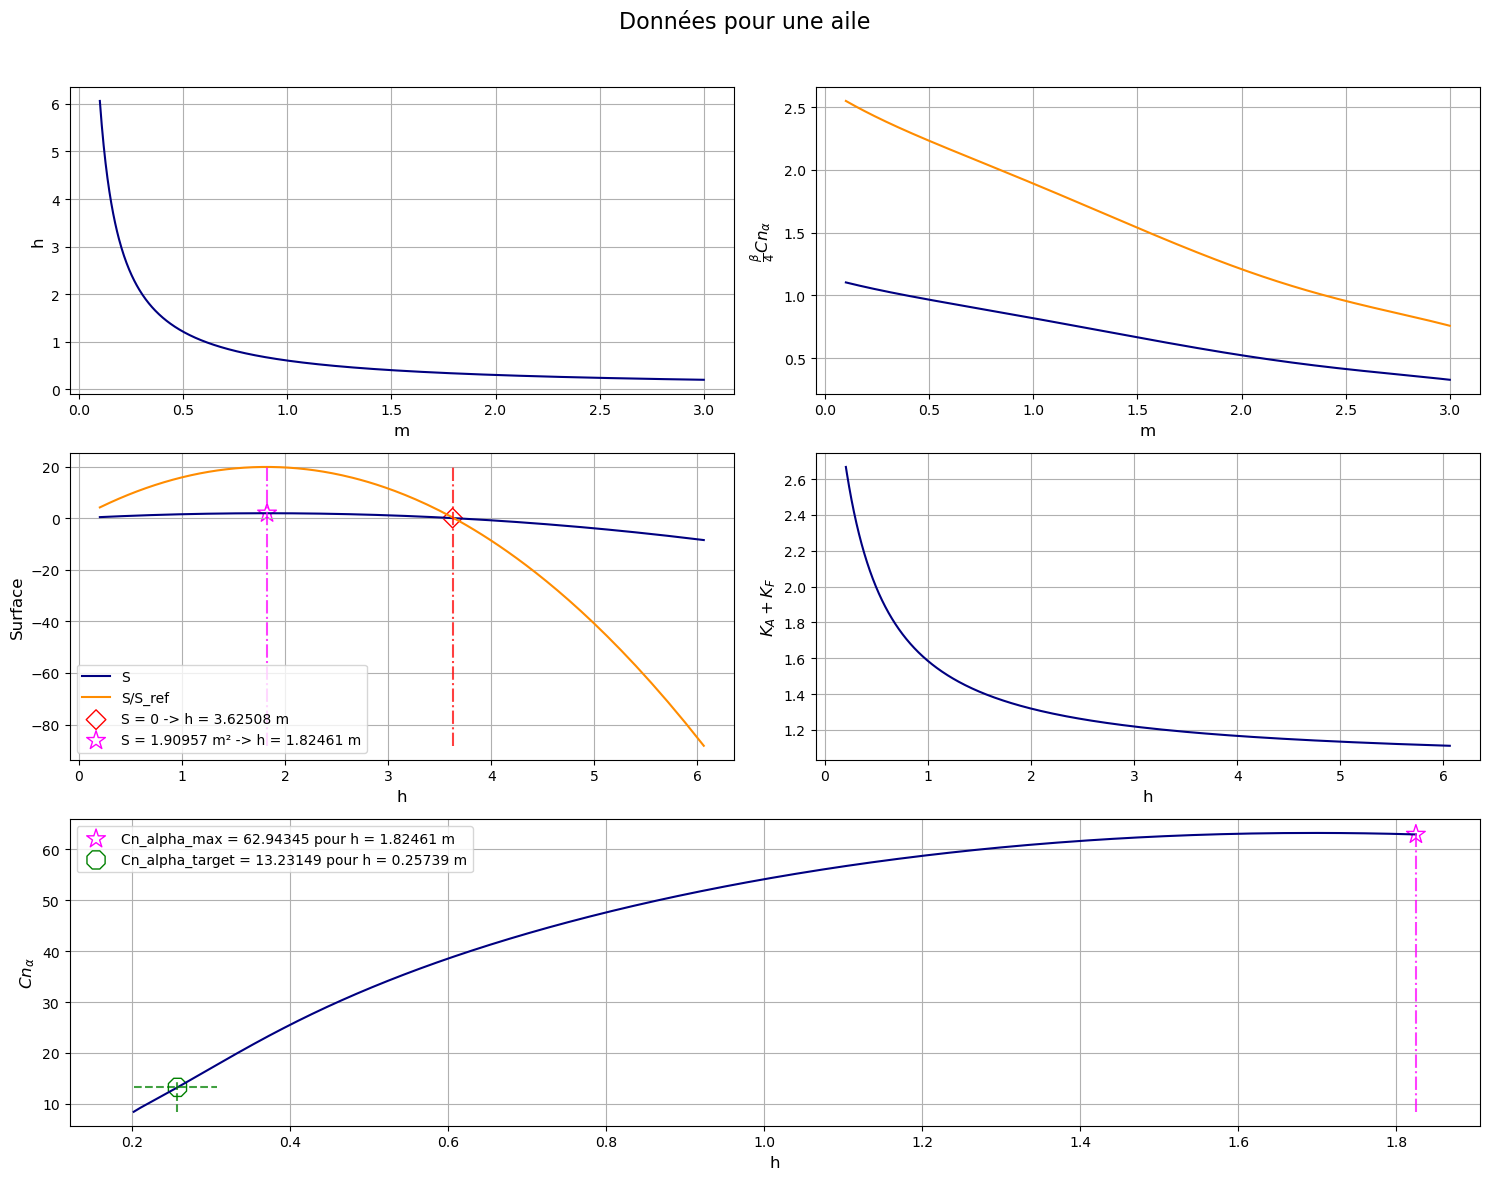

In [18]:
wing_data, wing_height = Get_section_component(corde=3*diametre, r_section=0.5 *diametre + h_AirIntakes, S_ref=0.25*np.pi*diametre**2, title="Données pour une aile", Cn_section=0.25 * Cn_dict['Cn_W'])

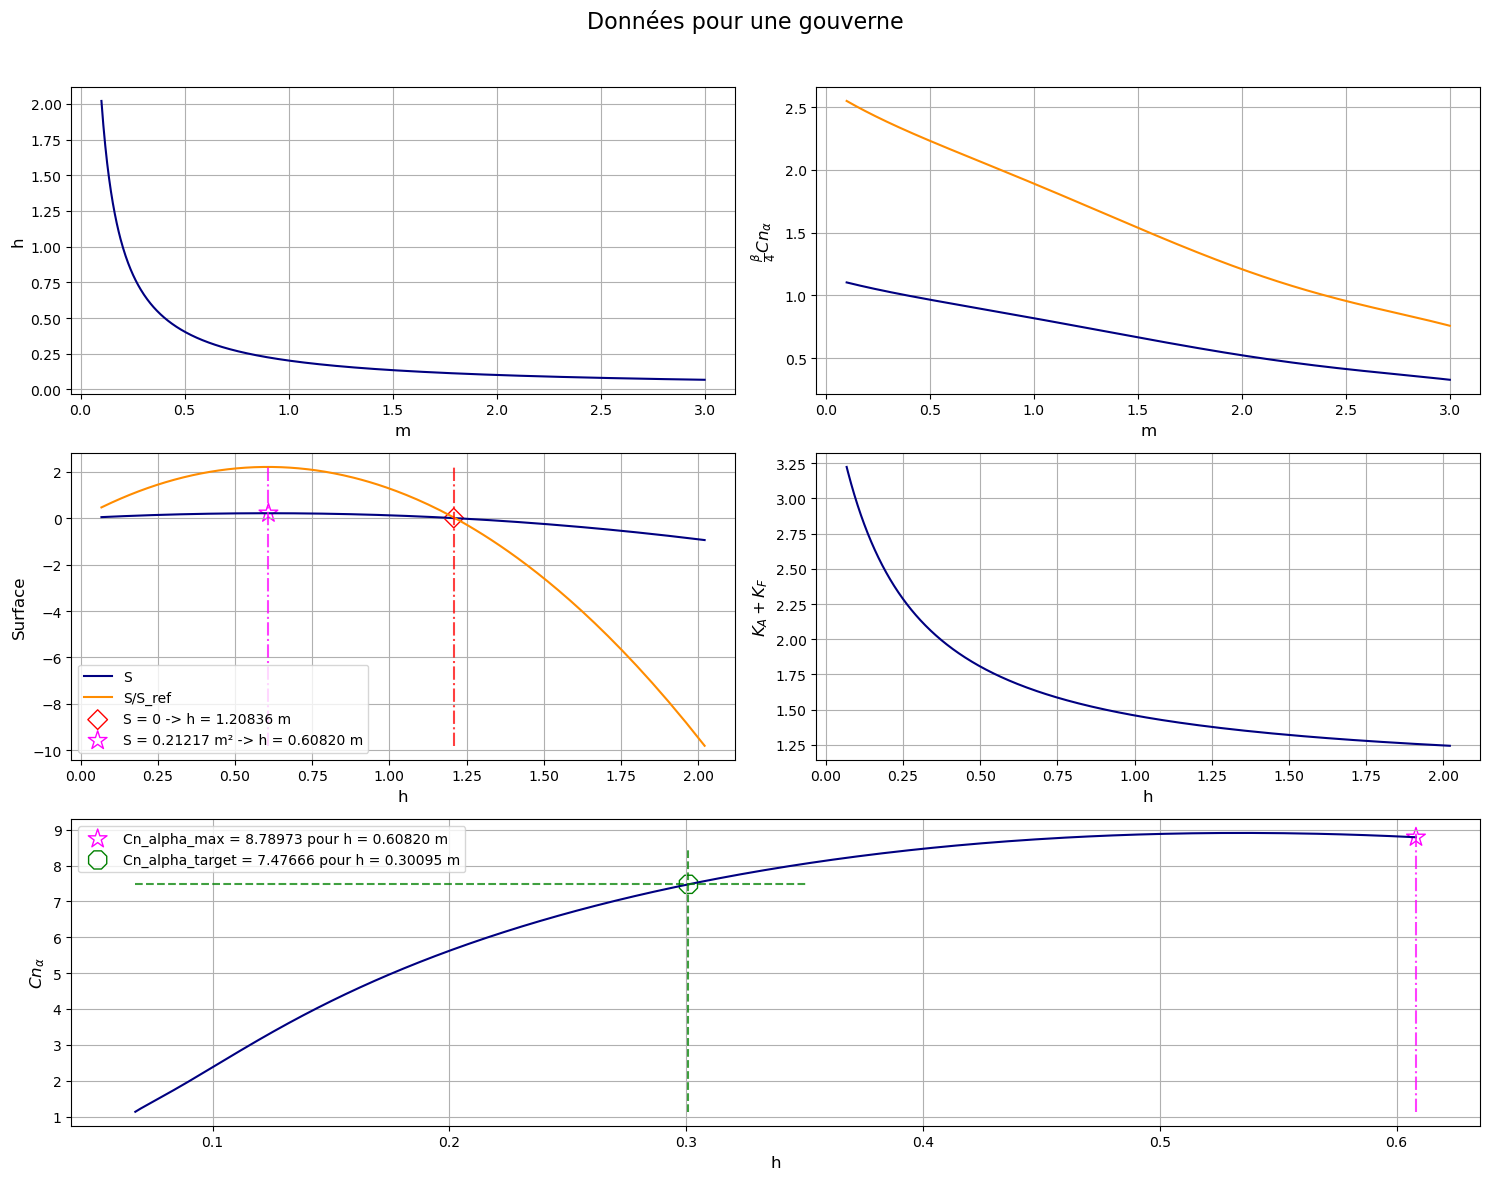

In [19]:
tail_data, tail_height = Get_section_component(corde=diametre, r_section=0.5*(diametre + h_AirIntakes), S_ref=0.25*np.pi*diametre**2, title="Données pour une gouverne", Cn_section=0.25 * Cn_dict['Cn_T'])

<div class="alert alert-info" align="center"><b>TRAINÉE</b></div> 

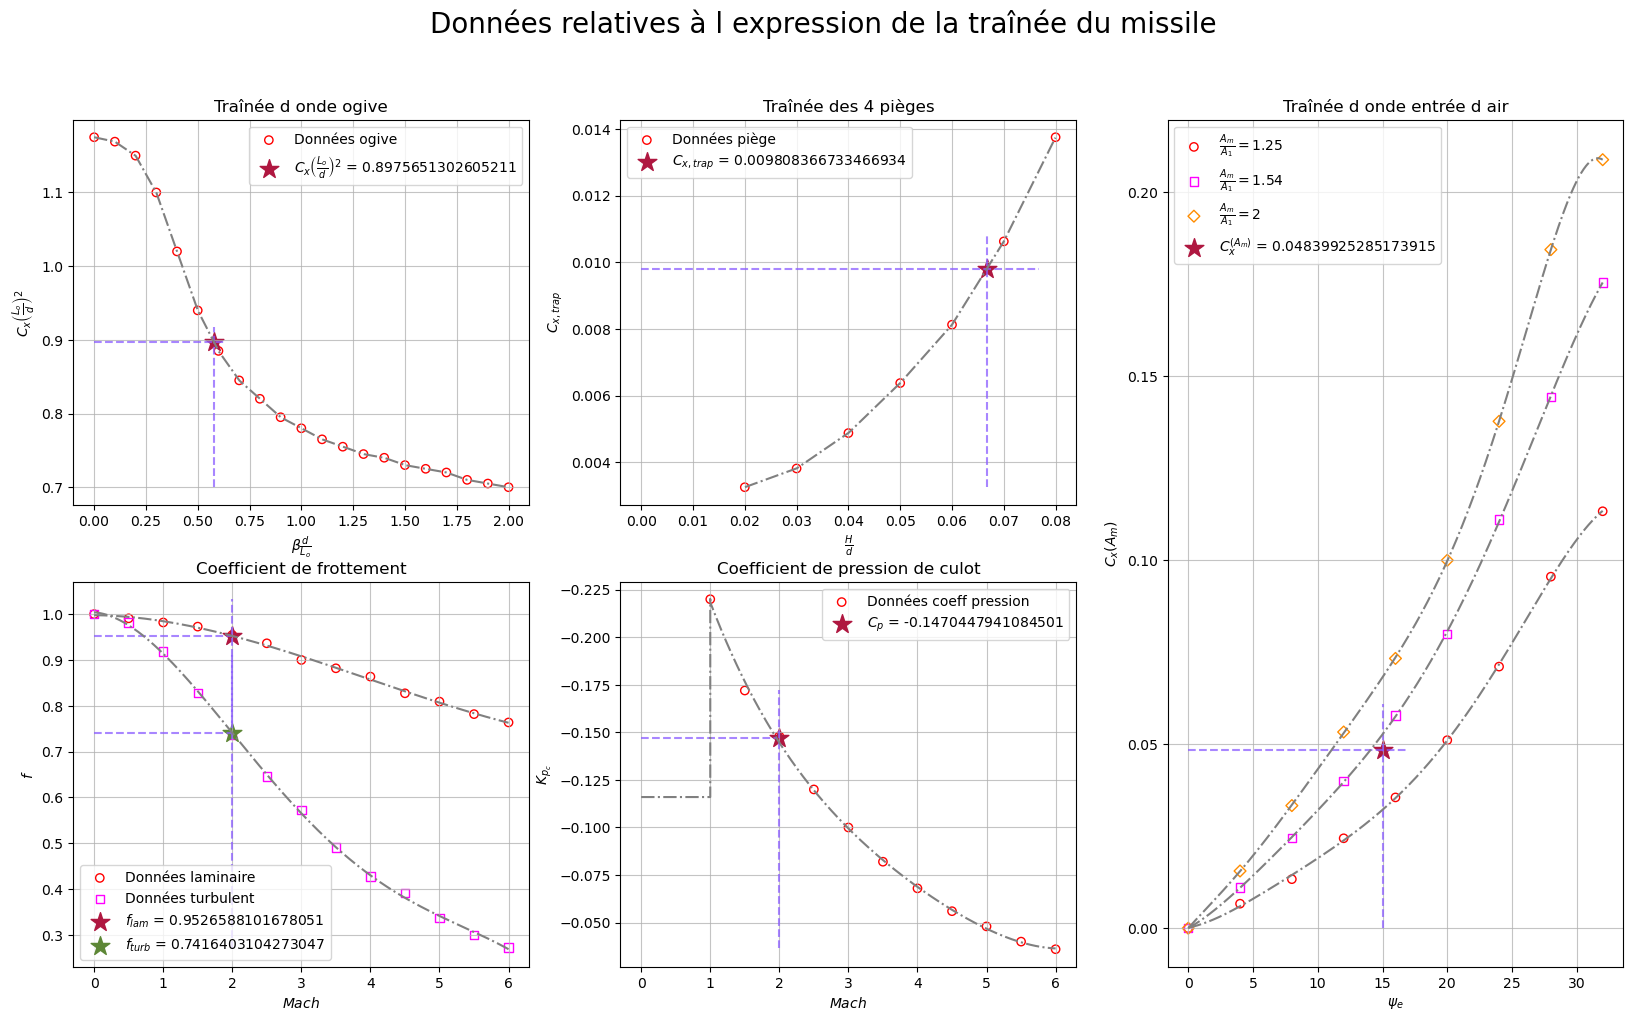


Tableau récapitulatif des informations de trainée d onde : 
        SECTION   Cx_wave
0         OGIVE  0.099729
1      PIEGE CL  0.009808
2  ENTRÉE D AIR  0.035945
3          AILE  0.050800
4      GOUVERNE  0.039598

Tableau récapitulatif des informations de trainée de frottement : 
        SECTION        Cf        Cx TYPE
0      FUSELAGE  0.001303  0.066604    T
1  ENTRÉE D AIR  0.005662  0.069273    T
2          AILE  0.006941  0.036238    T
3      GOUVERNE  0.008804  0.014493    T

Trainée de culot :  0.12038641282066526


In [20]:
diametre_dict = {
    'diametre': diametre,
    'internal_diameter': internal_diameter,
    'external_diameter': external_diameter,
    'thickness': thickness,
    'h_AirIntakes': h_AirIntakes,
    'S_ref': 0.25 * np.pi * diametre**2
}

target_dict = {
    'ogive': np.sqrt(3) * (diametre/row['L_ogive']),
    'trap': 1 / 15,
    'phi': 15,
    'ratio': ((internal_diameter + 2*thickness) / external_diameter)**2,
    'mach': Mach_cruise
}

airfoil_data = {
    'aile': {
        'ratio_ec': 3/100,
        'K': 6,
        'S': (wing_height * (2 * 3 * diametre) - wing_height * np.tan(np.deg2rad(30))) / (0.25 * np.pi * diametre**2),
        'height': wing_height,
        'corde': 3 * diametre
    },

    'gouverne': {
        'ratio_ec': 6/100,
        'K': 4,
        'S': (tail_height * (2 * 3 * diametre) - tail_height * np.tan(np.deg2rad(30))) / (0.25 * np.pi * diametre**2),
        'height': tail_height,
        'corde': diametre
    },

    'ogive': {
        'coeff': coeff_ogive,
        'length': row['L_ogive']
    }
}

drag_dict = Get_drag_data(target_dict, diametre_dict, row, airfoil_data)

In [21]:
Cx_tot = np.sum([Cx_val for Cx_val in drag_dict.values()]) * 1.1
print(f'{colored("Coefficient de traînée totale : ", "yellow")} {Cx_tot}')

Coefficient de traînée totale :  0.5971621170970649
